In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [9]:
!pip list torch

Package                   Version
------------------------- ------------
alembic                   1.12.1
aliyun-python-sdk-core    2.14.0
aliyun-python-sdk-kms     2.16.2
ansi2html                 1.8.0
anyio                     4.1.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
astroid                   3.0.1
asttokens                 2.4.0
async-lru                 2.0.4
attrs                     23.1.0
Babel                     2.13.1
backcall                  0.2.0
beautifulsoup4            4.12.2
bleach                    6.1.0
blinker                   1.7.0
certifi                   2023.7.22
cffi                      1.16.0
charset-normalizer        3.3.0
click                     8.1.7
cloudpickle               2.2.1
colorama                  0.4.6
colored-glog              1.3.0
coloredlogs               15.0.1
comm                      0.1.4
ConfigArgParse            1.7
contourpy                 1.1.1
crcmod             

In [10]:
torch.__version__

'2.1.0+cu121'

In [ ]:
!unrar x /content/drive/MyDrive/DEV_000F3102E45A_22_October_2023_10_44_29_jpg.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/DEV_000F3102E45A_22_October_2023_10_44_29_jpg.rar

Creating    images                                                    OK
Extracting  images/0_left_2023_10_22_10_44_29.jpg                          0%  OK 
Extracting  images/100_left_2023_10_22_10_44_46.jpg                        0%  OK 
Extracting  images/101_left_2023_10_22_10_44_46.jpg                        0%  OK 
Extracting  images/102_left_2023_10_22_10_44_46.jpg                        0%  OK 
Extracting  images/103_left_2023_10_22_10_44_47.jpg                        0%  OK 
Extracting  images/104_left_2023_10_22_10_44_47.jpg                        0%  OK 
Extracting  images/105_left_2023_10_22_10_44_47.jpg                        0%  OK 
Extracting  images/1067_left_2023_10_22_10_47_27.jpg                       0%  OK 
Extracting  images/1068_l

In [1]:
import json
import os
import numpy as np
import pandas as pd
import torch
import torchvision
from PIL import Image
from torch.utils.data import Dataset
from shapely.geometry import Polygon
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py

--2023-11-26 18:46:29--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: ‘engine.py’


engine.py             0%[                    ]       0  --.-KB/s               
engine.py           100%[===================>]   3.97K  --.-KB/s    in 0s      

2023-11-26 18:46:29 (65.4 MB/s) - ‘engine.py’ saved [4063/4063]

--2023-11-26 18:46:29--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.


In [2]:
from detection import utils,transforms,coco_eval,coco_utils
from detection.engine import train_one_epoch, evaluate

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "masks"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))
    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if xmin == xmax or ymin == ymax:
                continue
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
from torchvision.transforms import v2 as T
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [5]:
def get_model_instance_segmentation(num_classes:int):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [6]:
model = get_model_instance_segmentation(num_classes=2)

In [ ]:
import torchinfo
torchinfo.summary(mode=model)

In [17]:
root_dir = r"D:\graval detection project\datasets\unperpared data\images under water\DEV_000F3102E45A_22_October_2023_10_44_29_jpg"
transforms = get_transform(train=True)
dataset = CustomDataset(
        root=root_dir,
        transforms=transforms)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-2, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=5,
                                                   gamma=0.1)
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=utils.collate_fn,
    pin_memory=False
)
num_epochs = 10
device = torch.device("cpu")
print(device)
model.to(device)
for epoch in range(num_epochs):
        run=train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
        lr_scheduler.step()
        evaluate(model, data_loader, device=device)

cpu


KeyboardInterrupt: 

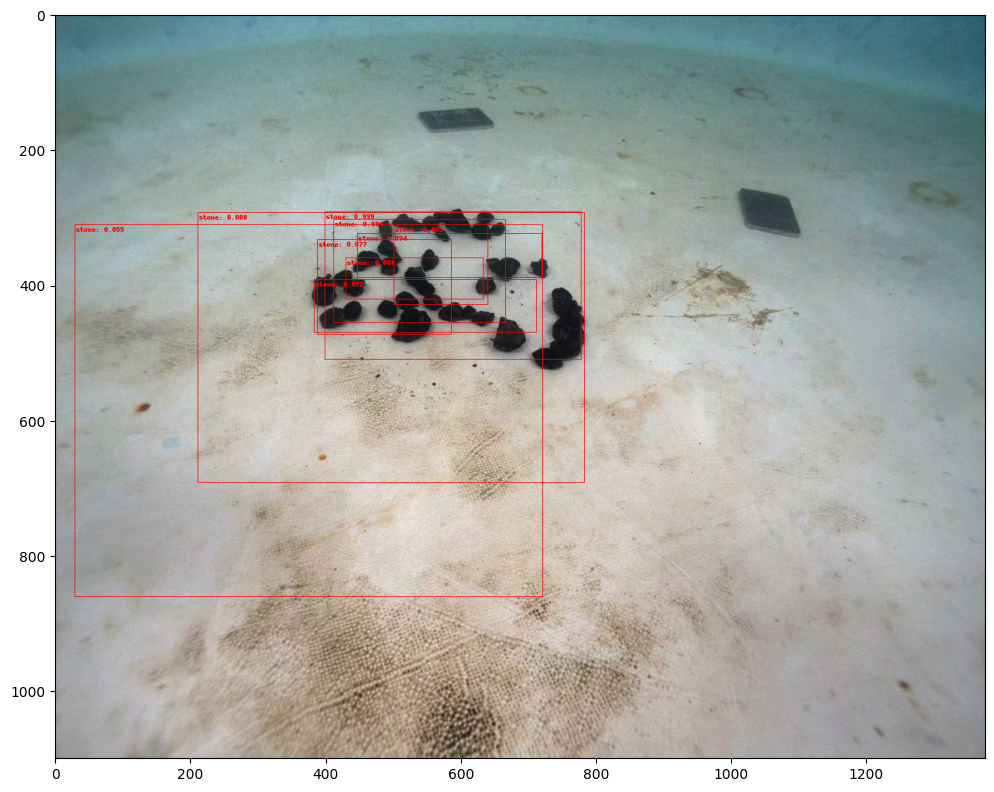

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
test=r"/content/images/133_left_2023_10_22_10_44_52.jpg"
image = read_image(test)
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"stone: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"]
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] >=0.1).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.2, colors="green")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [ ]:
print(pred["boxes"])

tensor([[399.5537, 292.3679, 778.7164, 510.3171],
        [412.6888, 303.2516, 666.5576, 456.2682],
        [447.0803, 324.2172, 720.3475, 389.8848],
        [211.7322, 293.5160, 783.3342, 692.0176],
        [388.9870, 333.2180, 586.0803, 473.3236],
        [383.1368, 392.2585, 712.9292, 470.8636],
        [430.7133, 360.9658, 633.7264, 421.0163],
        [501.2540, 311.2120, 640.8521, 429.0163],
        [ 29.7483, 311.2657, 721.9089, 861.6812]], device='cuda:0')
